In [1]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),      # Randomly rotate by up to 30 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

dataset_classify = datasets.ImageFolder('data/preprocessed')

train_size = int(0.8 * len(dataset_classify))
test_size = len(dataset_classify) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_classify, [train_size, test_size])

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# classes in train_loader:
for x, y in train_loader:
    print(y)
    break

tensor([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1])


In [4]:
# Load pretrained model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

modelOutputFeats = model.fc.in_features
model.fc = nn.Linear(modelOutputFeats, len(dataset_classify.classes))

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [6]:
# use gpu if available
device = torch.device("cuda:0") # change to CPU if no CUDA
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [7]:
from tqdm import tqdm
num_epochs = 15 # Number of epochs

for epoch in range(num_epochs):
    # Training loop
    model.train()

    running_loss = 0.0
    num_batches = 0
    train_correct = 0

    #unfreeze last block of ResNet
    if epoch == 7:
        for param in model.layer4.parameters():
            param.requires_grad = True


    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        running_loss, num_batches = running_loss + loss.item(), num_batches + 1
        # Backward and optimize
        loss.backward()
        optimizer.step()
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/num_batches:.4f}, correct during training: {train_correct}')

    model.eval()
    # Validation loop
    with torch.no_grad():
        running_accuracy = 0.0
        total_correct = 0 
        num_batches = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            num_batches += 1
            total_correct += (outputs.argmax(dim=1) == labels).type(torch.float).sum().item()
        running_accuracy = total_correct / len(test_loader.dataset) * 100
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {running_accuracy}%')


100%|██████████| 1997/1997 [22:35<00:00,  1.47it/s]


Epoch [1/15], Loss: 0.5818, correct during training: 88691
Epoch [1/15], Test Accuracy: 70.51550909261636%


100%|██████████| 1997/1997 [11:02<00:00,  3.02it/s]


Epoch [2/15], Loss: 0.5561, correct during training: 91096
Epoch [2/15], Test Accuracy: 71.51397539829102%


100%|██████████| 1997/1997 [10:59<00:00,  3.03it/s]


Epoch [3/15], Loss: 0.5482, correct during training: 91606
Epoch [3/15], Test Accuracy: 72.0523334063664%


100%|██████████| 1997/1997 [11:03<00:00,  3.01it/s]


Epoch [4/15], Loss: 0.5441, correct during training: 92009
Epoch [4/15], Test Accuracy: 72.03668346427118%


100%|██████████| 1997/1997 [11:05<00:00,  3.00it/s]


Epoch [5/15], Loss: 0.5426, correct during training: 92176
Epoch [5/15], Test Accuracy: 71.88644402015713%


100%|██████████| 1997/1997 [11:04<00:00,  3.00it/s]


Epoch [6/15], Loss: 0.5397, correct during training: 92323
Epoch [6/15], Test Accuracy: 72.08363329055683%


100%|██████████| 1997/1997 [11:02<00:00,  3.02it/s]


Epoch [7/15], Loss: 0.5375, correct during training: 92654
Epoch [7/15], Test Accuracy: 72.15562302419481%


100%|██████████| 1997/1997 [13:20<00:00,  2.50it/s]


Epoch [8/15], Loss: 0.4695, correct during training: 98065
Epoch [8/15], Test Accuracy: 79.35459638799335%


100%|██████████| 1997/1997 [13:20<00:00,  2.49it/s]


Epoch [9/15], Loss: 0.3930, correct during training: 103793
Epoch [9/15], Test Accuracy: 81.78346740117061%


100%|██████████| 1997/1997 [13:24<00:00,  2.48it/s]


Epoch [10/15], Loss: 0.3431, correct during training: 107418
Epoch [10/15], Test Accuracy: 84.19355848383361%


100%|██████████| 1997/1997 [13:20<00:00,  2.50it/s]


Epoch [11/15], Loss: 0.3063, correct during training: 109979
Epoch [11/15], Test Accuracy: 85.48937368931735%


100%|██████████| 1997/1997 [13:17<00:00,  2.50it/s]


Epoch [12/15], Loss: 0.2756, correct during training: 111903
Epoch [12/15], Test Accuracy: 86.43150020344925%


100%|██████████| 1997/1997 [13:19<00:00,  2.50it/s]


Epoch [13/15], Loss: 0.2495, correct during training: 113524
Epoch [13/15], Test Accuracy: 86.94481830417227%


100%|██████████| 1997/1997 [13:23<00:00,  2.49it/s]


Epoch [14/15], Loss: 0.2281, correct during training: 114862
Epoch [14/15], Test Accuracy: 88.07787411186578%


100%|██████████| 1997/1997 [13:20<00:00,  2.49it/s]


Epoch [15/15], Loss: 0.2101, correct during training: 116015
Epoch [15/15], Test Accuracy: 88.2531534633322%


In [8]:
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
    'classes': dataset_classify.classes
}
torch.save(checkpoint, 'checkpoints/model_baseline_centercrop_unfreeze.pt')

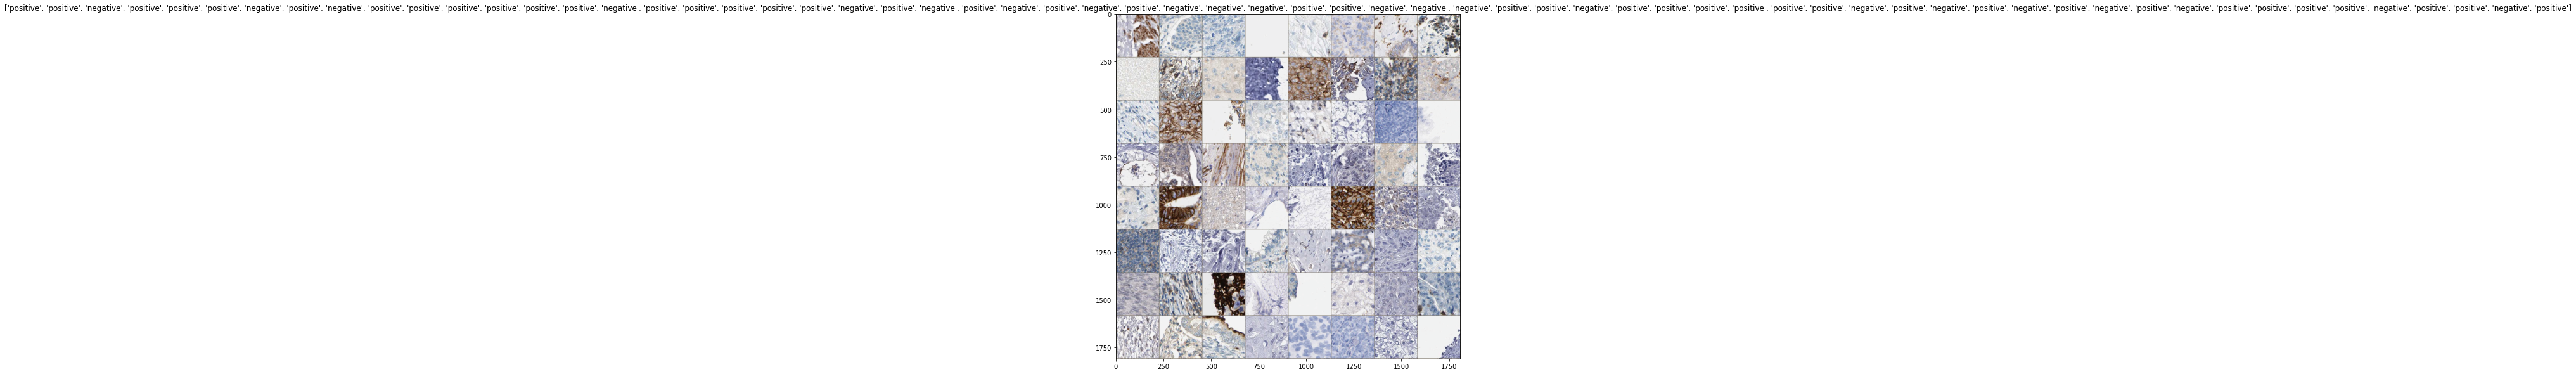

In [9]:
# visualize the test set
import torchvision
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
with torch.no_grad():
    inputs, classes = next(iter(test_loader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[dataset_classify.classes[x] for x in classes])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


attributions_occ shape:  torch.Size([1, 3, 224, 224])
input_image shape:  torch.Size([1, 3, 224, 224])


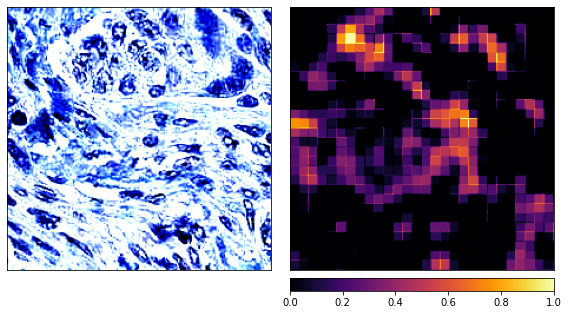

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


attributions_occ shape:  torch.Size([1, 3, 224, 224])
input_image shape:  torch.Size([1, 3, 224, 224])


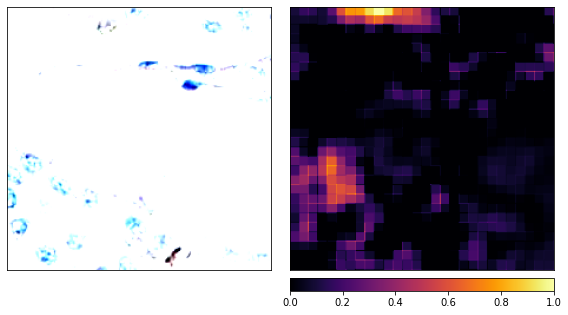

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


attributions_occ shape:  torch.Size([1, 3, 224, 224])
input_image shape:  torch.Size([1, 3, 224, 224])


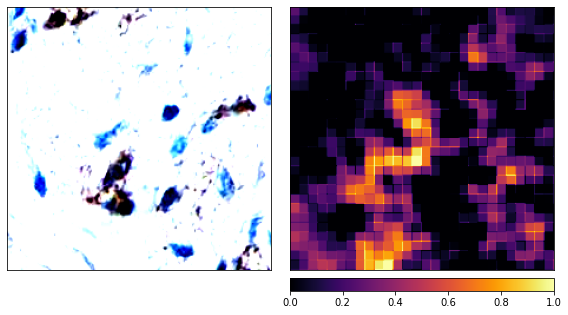

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


attributions_occ shape:  torch.Size([1, 3, 224, 224])
input_image shape:  torch.Size([1, 3, 224, 224])


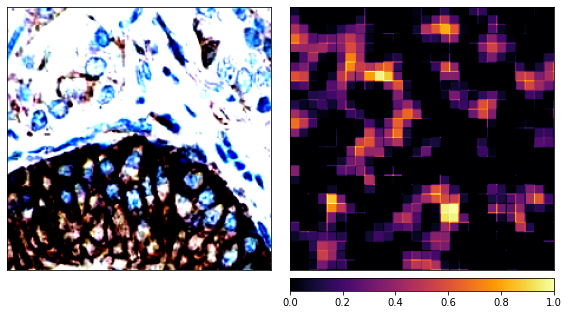

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


attributions_occ shape:  torch.Size([1, 3, 224, 224])
input_image shape:  torch.Size([1, 3, 224, 224])


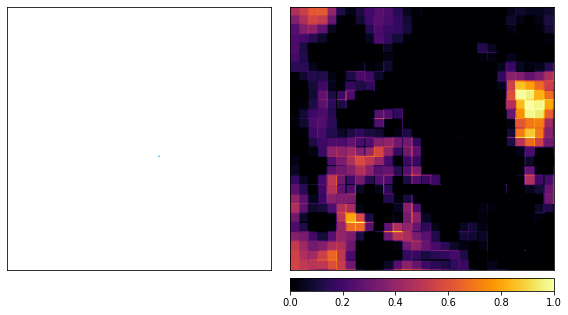

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


attributions_occ shape:  torch.Size([1, 3, 224, 224])
input_image shape:  torch.Size([1, 3, 224, 224])


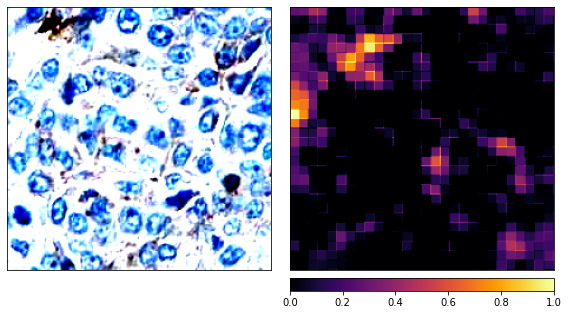

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


attributions_occ shape:  torch.Size([1, 3, 224, 224])
input_image shape:  torch.Size([1, 3, 224, 224])


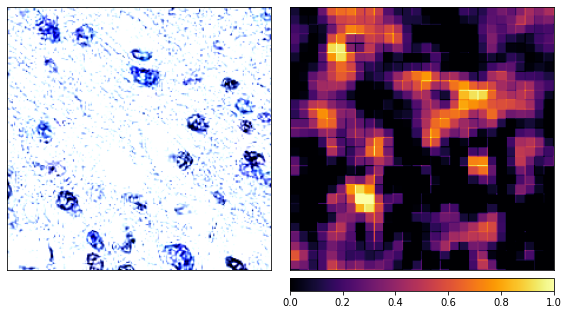

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


attributions_occ shape:  torch.Size([1, 3, 224, 224])
input_image shape:  torch.Size([1, 3, 224, 224])


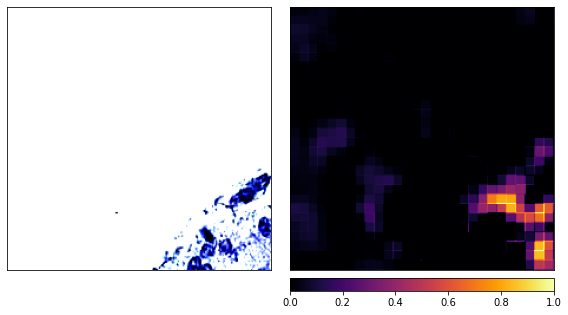

In [13]:
#captum occlusion visualization
from captum.attr import Occlusion
import matplotlib.pyplot as plt
from captum.attr import visualization as viz
occlusion = Occlusion(model)

random_idxs = [np.random.randint(0, len(test_dataset)) for i in range(8)]

for idx in random_idxs:
    input_image = test_dataset[idx][0].unsqueeze(0)
    input_image = input_image.to(device)
    attributions_occ = occlusion.attribute(input_image,
                                            strides = (3, 8, 8 ),
                                            target=classes[0],
                                            sliding_window_shapes=(3,15, 15),
                                            baselines=0)

    print("attributions_occ shape: ", attributions_occ.shape)
    print("input_image shape: ", input_image.shape)
    #visualization, use device
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                            np.transpose(input_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                            ["original_image", "heat_map"],
                                            ["all", "positive"],
                                            cmap="inferno",
                                            show_colorbar=True)